# Assignment 4: Random Forests and Gradient Boosting
## Christopher Rico
## MSDS 422

Boston Housing Study (Python)
This assignment builds on work completed for Assignment 3: Regression Models. You are asked to add random forests to the set of modeling methods being studied.
Using data from the Boston Housing Study case as described in "Marketing Data Science: Modeling Techniques for Predictive Analytics with R and Python" (Miller 2015)

Here we use data from the Boston Housing Study to evaluate regression modeling and ensemble methods within a cross-validation design.

Program revised by Thomas W. Milller (2017/09/29)

Scikit Learn documentation for this assignment:
*   http://scikit-learn.org/stable/modules/model_evaluation.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
*   http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html



---





# Ingest

### Development Environment Setup

In [1]:
#--------------------------------------------------------------------
#                       Dev Environment Setup
#--------------------------------------------------------------------

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 42

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from math import sqrt  # for root mean-squared error calculation

# modeling routines from Scikit Learn packages
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Utility Functions

In [0]:
#--------------------------------------------------------------------
#                              CORR_CHART
#       function for correlation heat map setup for seaborn
#    modified to allow for square heatmaps as well as triangle ones
#--------------------------------------------------------------------

def corr_chart(corr, tri=True):
    if tri is True:
        #screen top half to get a triangle
        top = np.zeros_like(corr, dtype=np.bool)
        top[np.triu_indices_from(top)] = True
    else:
        top = np.zeros_like(corr, dtype=np.bool)
        
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm',
        center = 0, square=True,
        linewidths=.5, cbar_kws={'shrink':.5},
        annot = True, annot_kws={'size': 9}, fmt = '.3f')
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')
    plt.savefig('plot-corr-map.pdf',
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
        orientation='portrait', papertype=None, format=None,
        transparent=True, pad_inches=0.25, frameon=None)

### Getting and Examining Data

In [3]:
#--------------------------------------------------------------------
#                     Getting and Examining Data
#--------------------------------------------------------------------

#get data from github raw file
url = 'https://raw.githubusercontent.com/christophrico/MSDS_422/master/assign-3/boston.csv'
boston_input = pd.read_csv(url)

# add in log median value of homes as another column
boston_input['log_mv'] = np.log(boston_input['mv'])

boston_input = boston_input.rename( columns = {'mv' : 'median_value',
                                   'log_mv' : 'log_median_value',
                                   'nox' : 'air_pollution',
                                   'crim' : 'crime_rate',
                                   'zn' : 'pct_zoned_lots',
                                   'indus' : 'pct_industrial',
                                   'chas' : 'is_waterfront',
                                   'rooms' : 'avg_rooms',
                                   'age' : 'pct_pre_war',
                                   'dis' : 'avg_commute',
                                   'rad' : 'highway_access',
                                   'tax' : 'tax_rate',
                                   'ptratio' : 'pt_ratio',
                                   'lstat' : 'pct_poor'})

# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
print(boston_input.head())
print(boston_input.tail())


boston DataFrame (first and last five rows):
  neighborhood  crime_rate  ...  median_value  log_median_value
0       Nahant     0.00632  ...          24.0          3.178054
1   Swampscott     0.02731  ...          21.6          3.072693
2   Swanpscott     0.02729  ...          34.7          3.546740
3   Marblehead     0.03237  ...          33.4          3.508556
4   Marblehead     0.06905  ...          36.2          3.589059

[5 rows x 15 columns]
    neighborhood  crime_rate  ...  median_value  log_median_value
501     Winthrop     0.06263  ...          22.4          3.109061
502     Winthrop     0.04527  ...          20.6          3.025291
503     Winthrop     0.06076  ...          23.9          3.173878
504     Winthrop     0.10959  ...          22.0          3.091042
505     Winthrop     0.04741  ...          19.0          2.944439

[5 rows x 15 columns]


In [4]:
print('\nGeneral description of the boston_input DataFrame:')
print(boston_input.info())


General description of the boston_input DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neighborhood      506 non-null    object 
 1   crime_rate        506 non-null    float64
 2   pct_zoned_lots    506 non-null    float64
 3   pct_industrial    506 non-null    float64
 4   is_waterfront     506 non-null    int64  
 5   air_pollution     506 non-null    float64
 6   avg_rooms         506 non-null    float64
 7   pct_pre_war       506 non-null    float64
 8   avg_commute       506 non-null    float64
 9   highway_access    506 non-null    int64  
 10  tax_rate          506 non-null    int64  
 11  pt_ratio          506 non-null    float64
 12  pct_poor          506 non-null    float64
 13  median_value      506 non-null    float64
 14  log_median_value  506 non-null    float64
dtypes: float64(11), int64(3), object(1)
mem

In [5]:
# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\nGeneral description of the boston DataFrame:')
print(boston.info())


General description of the boston DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   crime_rate        506 non-null    float64
 1   pct_zoned_lots    506 non-null    float64
 2   pct_industrial    506 non-null    float64
 3   is_waterfront     506 non-null    int64  
 4   air_pollution     506 non-null    float64
 5   avg_rooms         506 non-null    float64
 6   pct_pre_war       506 non-null    float64
 7   avg_commute       506 non-null    float64
 8   highway_access    506 non-null    int64  
 9   tax_rate          506 non-null    int64  
 10  pt_ratio          506 non-null    float64
 11  pct_poor          506 non-null    float64
 12  median_value      506 non-null    float64
 13  log_median_value  506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None


In [6]:
print('\nDescriptive statistics of the boston DataFrame:')
print(boston.describe())


Descriptive statistics of the boston DataFrame:
       crime_rate  pct_zoned_lots  ...  median_value  log_median_value
count  506.000000      506.000000  ...    506.000000        506.000000
mean     3.613524       11.363636  ...     22.528854          3.034558
std      8.601545       23.322453  ...      9.182176          0.408275
min      0.006320        0.000000  ...      5.000000          1.609438
25%      0.082045        0.000000  ...     17.025000          2.834680
50%      0.256510        0.000000  ...     21.200000          3.054001
75%      3.677082       12.500000  ...     25.000000          3.218876
max     88.976200      100.000000  ...     50.000000          3.912023

[8 rows x 14 columns]




---



# EDA

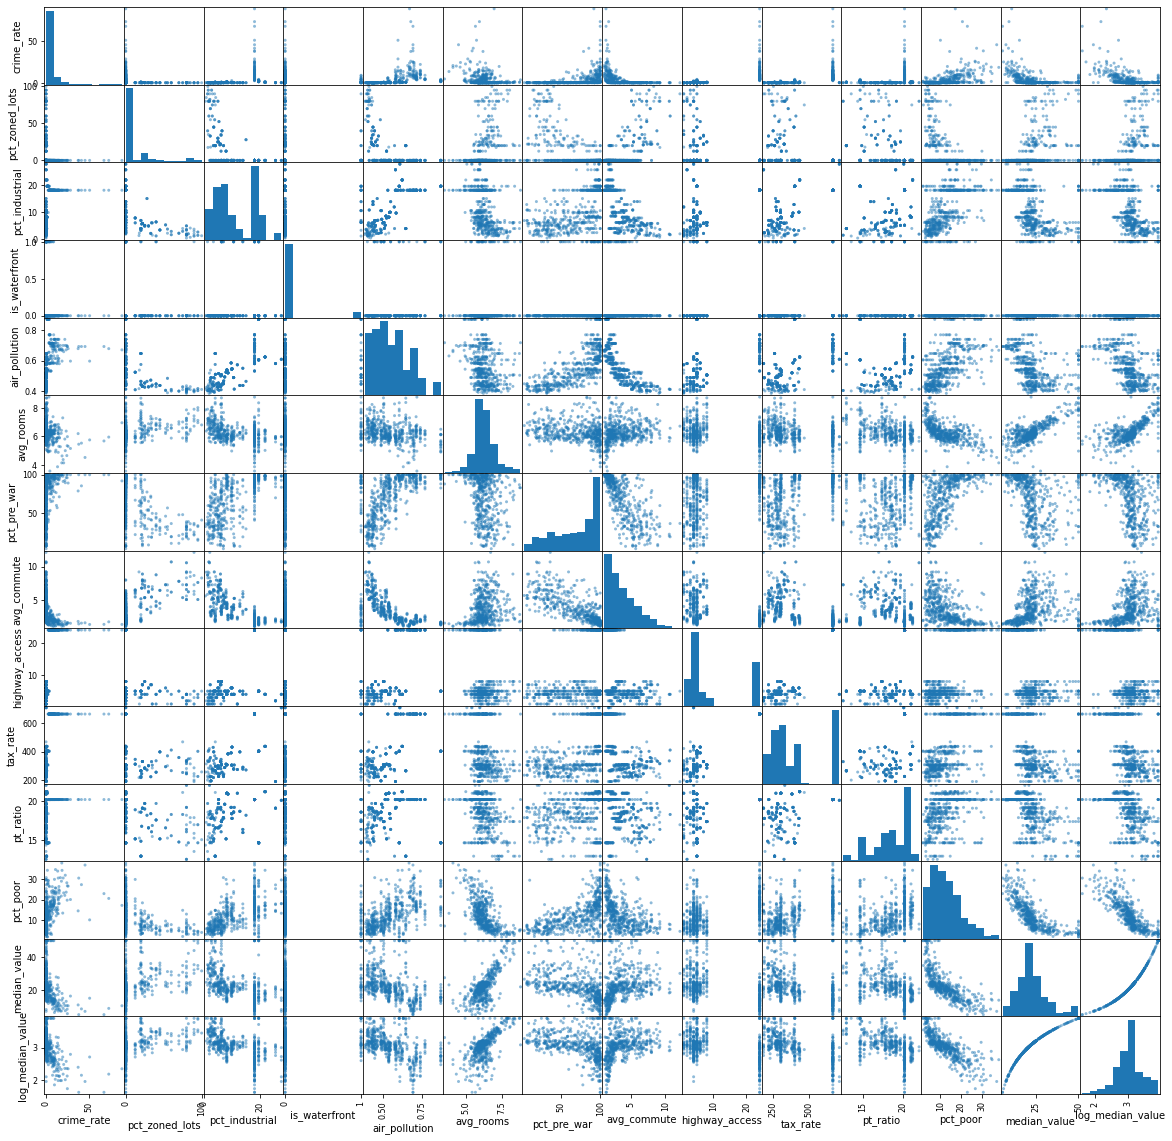

In [7]:
# plot a scatter matrix to see what kinds of patterns emerge in data
pd.plotting.scatter_matrix(boston, diagonal='hist', figsize=(20,20)); plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

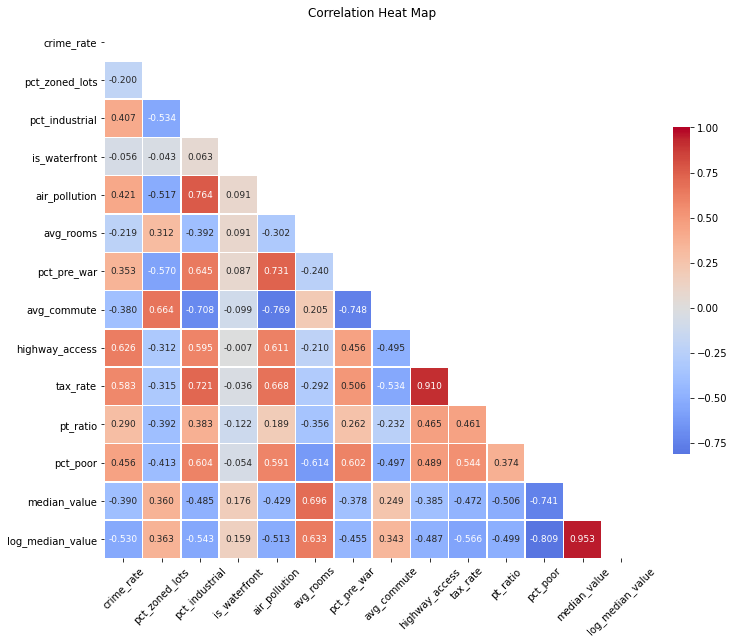

In [8]:
#plot a correlation heatmap as a way to see any numerical intercorrelations
house_corr = boston.corr()
corr_chart(house_corr)

In [9]:
#sort so strongest positive correlations are at top
#and strongest negative correlations are at bottom for median home values
print(house_corr.loc['crime_rate':'pct_poor','median_value':'median_value']\
      .sort_values(by='median_value', ascending=False))

                median_value
avg_rooms           0.696304
pct_zoned_lots      0.360386
avg_commute         0.249315
is_waterfront       0.175663
pct_pre_war        -0.377999
highway_access     -0.384766
crime_rate         -0.389582
air_pollution      -0.429300
tax_rate           -0.471979
pct_industrial     -0.484754
pt_ratio           -0.505655
pct_poor           -0.740836


In [10]:
#and do the same for the log median home vaues
print(house_corr.loc['crime_rate':'pct_poor','log_median_value':'log_median_value']\
      .sort_values(by='log_median_value', ascending=False))


                log_median_value
avg_rooms               0.632536
pct_zoned_lots          0.363396
avg_commute             0.342527
is_waterfront           0.158569
pct_pre_war            -0.455029
highway_access         -0.486818
pt_ratio               -0.499433
air_pollution          -0.513431
crime_rate             -0.530001
pct_industrial         -0.543195
tax_rate               -0.566214
pct_poor               -0.809234


---

# Modeling

 ### Modeling Utility Functions
These are a few functions I've written to automate cross-validation testing across several regressors at once. 

In [0]:
#--------------------------------------------------------------------
#                           cv_chart
# Function to make scatterplot predicted vs actual reponse variables
# Input: predicted, a numpy array of predicted response vars
#        y, a numpy array of actual response vars
#        regre_name, a list of regressor names (for printing)
# Output: Scatterplot with line of predicted vs actual y 
# Adapted from Scikit-Learn documentation
#--------------------------------------------------------------------
def cv_chart(predicted, y, regre_name):
  fig, ax = plt.subplots()
  ax.scatter(y, predicted, edgecolors=(0, 0, 0))
  ax.plot([y.min(), y.max()], [predicted.min(), predicted.max()], 'k--', lw=4)
  ax.set_title("{} Measured vs Predicted Values".format(regre_name))
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

In [0]:
#--------------------------------------------------------------------
#                           cv_compare_regressors
# Function to automate cross-fold validation between various regression models
# Input: X_data, numpy array of explanatory data
#        y_data, numpy array of response data
#        regressors, list of tuples of names and
#                    sklearn regressor instances
#        n_folds, int for the number of folds you want to run (default 5)
# Output: RMSE per regressor, chart of predicted vs actual y
# Adapted from Scikit-Learn documentation
#--------------------------------------------------------------------
def cv_compare_regressors(X_data, y_data, regressors, n_folds=5):
  #set up dataframe to collect results
  score_df = pd.DataFrame(columns=['Model',
                                  'Train RMSE',
                                  'Test RMSE',
                                  'Train Score',
                                  'Test Score'])

  #compare the regressors across 10 different folds
  for name, reg in regressors:
    #perform the cross validation
    cv_res = cross_validate(
                            reg,
                            X_data,
                            y_data,
                            cv=n_folds,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True,
                            )

    #calculate the training rmse
    train_mse = abs( np.mean( cv_res['train_neg_mean_squared_error'] ) )
    train_rmse = sqrt(train_mse)
    #calculate the test rmse
    test_mse = abs( np.mean( cv_res['test_neg_mean_squared_error'] ) )
    test_rmse = sqrt(test_mse)
    #get out the train and test scores
    train_score = np.mean( cv_res['train_r2'] )
    test_score = np.mean( cv_res['test_r2'] )

    #save the results into a dataframe
    score_df = score_df.append({
                                'Model' : name,
                                'Train RMSE' : train_rmse,
                                'Test RMSE' : test_rmse,
                                'Train Score' : train_score,
                                'Test Score' : test_score
                              },
                              sort=False,
                              ignore_index=True
                              )


    #make chart of each predicted vs measured output
    y_pred = cross_val_predict(reg, X_data, y_data, cv=n_folds)
    cv_chart(y_pred, y_data, name)
    
    #end loop

  display(score_df)

### Data Standardization
This is a data standardization pipeline supplied in the jump start program. It seeks to level the playing field for each of the regressors.

In [13]:
#--------------------------------------------------------------------
#                Model Setup: Data Standardization
#--------------------------------------------------------------------

# set up preliminary data for data for fitting the models 
prelim_model_data = np.array([boston.crime_rate,
                              boston.pct_zoned_lots,
                              boston.pct_industrial,
                              boston.is_waterfront,
                              boston.air_pollution,
                              boston.avg_rooms,
                              boston.pct_pre_war,
                              boston.avg_commute,
                              boston.highway_access,
                              boston.tax_rate,
                              boston.pt_ratio,
                              boston.pct_poor
                             ]).T

print('\nData dimensions:', prelim_model_data.shape)


Data dimensions: (506, 12)


In [14]:
# standard scores for the columns... along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))
# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

StandardScaler(copy=True, with_mean=True, with_std=True)
[3.61352356e+00 1.13636364e+01 1.11367787e+01 6.91699605e-02
 5.54695059e-01 6.28463439e+00 6.85749012e+01 3.79504269e+00
 9.54940711e+00 4.08237154e+02 1.84555336e+01 1.26530632e+01]
[8.59304135e+00 2.32993957e+01 6.85357058e+00 2.53742935e-01
 1.15763115e-01 7.01922514e-01 2.81210326e+01 2.10362836e+00
 8.69865112e+00 1.68370495e+02 2.16280519e+00 7.13400164e+00]


In [15]:
# the model data will be standardized form of preliminary model data
X = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', X.shape)


Dimensions for model_data: (506, 12)


### Sklearn Model Instantiation
And here is where we actually instantiate the regressors we want to use, input their hyperparameters, etc.

In [0]:
#--------------------------------------------------------------------
#      Model Setup: Individual Regressors vs. Ensemble Regressors
#--------------------------------------------------------------------

#instantiate the regressors we want to use
lin_reg = LinearRegression(fit_intercept=True)
ridge_reg = Ridge(alpha = 0.1,
                  solver = 'cholesky',
                  fit_intercept = True,
                  normalize = False,
                  random_state = RANDOM_SEED
                  )
lasso_reg = Lasso(alpha=0.1,
                  max_iter=10000,
                  tol=0.01,
                  fit_intercept=True,
                  random_state=RANDOM_SEED
                  )
en_reg = ElasticNet(alpha=0.1,
                    l1_ratio=0.2,
                    max_iter=10000,
                    tol=0.01,
                    fit_intercept=True,
                    normalize=False,
                    random_state=RANDOM_SEED
                    )
rf_reg = RandomForestRegressor(bootstrap=True,
                               max_depth=4,
                               max_features=3,
                               n_estimators=150,
                               random_state=RANDOM_SEED
                               )
gb_reg = GradientBoostingRegressor(max_depth=3,
                                   n_estimators=60,
                                   learning_rate=0.2,
                                   random_state=RANDOM_SEED
                                  )

# create tuples of the regressor and its name, for pretty printing
regres = [
          ('Linear', lin_reg),
          ('Ridge', ridge_reg),
          ('Lasso', lasso_reg),
          ('Elastic Net', en_reg),
          ('Random Forest', rf_reg),
          ('Gradient Boost', gb_reg)
         ]

### Model Comparison
Now let's actually run some k-fold comparisons across all the regressors.

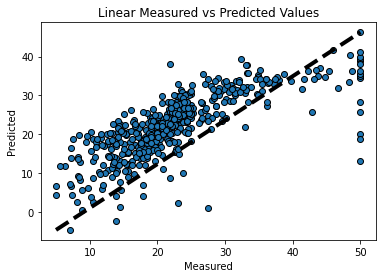

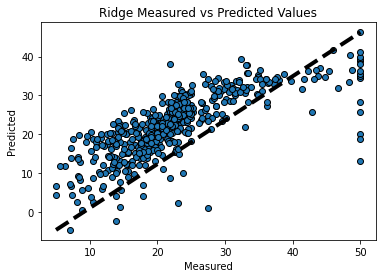

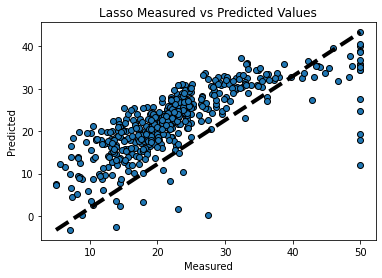

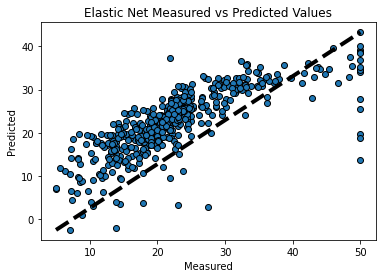

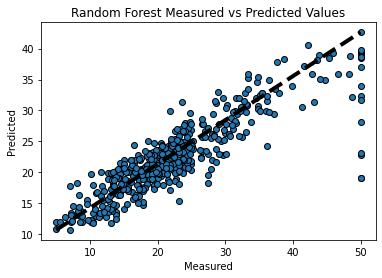

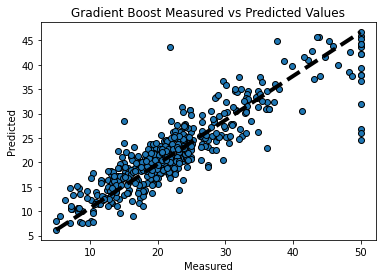

,Model,Train RMSE,Test RMSE,Train Score,Test Score
0,Linear,4.569606,5.990063,0.746679,0.383111
1,Ridge,4.569608,5.988431,0.746679,0.383584
2,Lasso,4.621793,5.945974,0.740780,0.410406
3,Elastic Net,4.653609,5.763485,0.737233,0.447256
4,Random Forest,2.982805,5.019145,0.891739,0.578182
5,Gradient Boost,1.207231,4.220117,0.982195,0.698762


In [17]:
#--------------------------------------------------------------------
#                Model Setup: K-Fold Comparison
#--------------------------------------------------------------------
#we are going to use median_value as a response variable
y = np.ravel( np.array([boston.median_value]).T )

#compare the models across 5 folds of data
cv_compare_regressors(X, y, regres, 5)

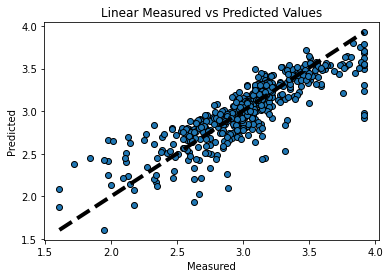

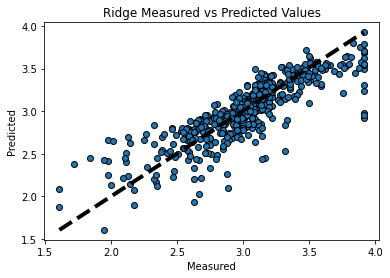

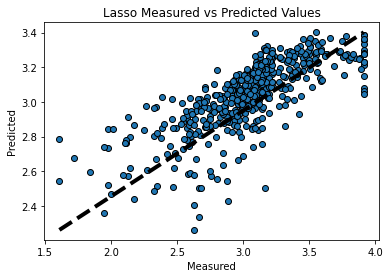

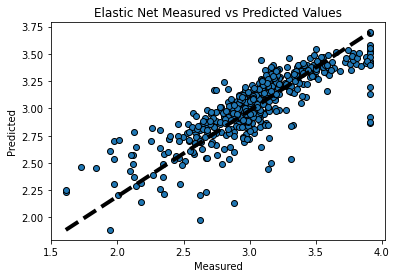

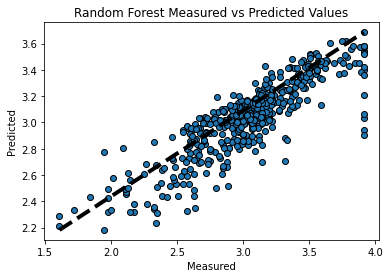

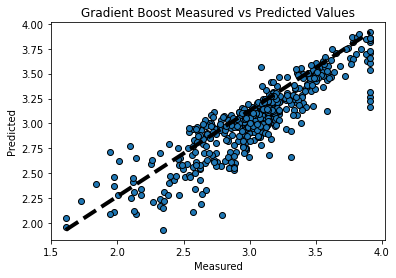

,Model,Train RMSE,Test RMSE,Train Score,Test Score
0,Linear,0.184392,0.219550,0.792604,0.616724
1,Ridge,0.184392,0.219516,0.792604,0.616913
2,Lasso,0.243521,0.287775,0.636564,0.279078
3,Elastic Net,0.203180,0.233682,0.748130,0.560388
4,Random Forest,0.141744,0.217191,0.877383,0.600174
5,Gradient Boost,0.059623,0.190614,0.978319,0.696489


In [18]:
#now let's try to use log_median_value as a response variable
y = np.ravel( np.array([boston.log_median_value]).T )

#compare the models across 5 folds of data
cv_compare_regressors(X, y, regres, 5)



---



# Conclusion

Recommended regressor is a gradient boosting regressor while using median home values as a target variable. More tuning of hyperparameters could lead to higher test accuracy for this regressor, but it performs best out of all those tested.
